# _Kinetics of Reactions_ (_Kinexns_)

## 1. Building and solving the chemical kinetic model from chemkin input files

In [1]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append("/Users/chowdhury/Documents/kinexns")

from kinexns.ode_builder import *
from kinexns.ode_solver import *
from kinexns.parse_chemkin import *

Could not find GLIMDA.


setting up the paths for the input files. Since these input files are not in chemkin format, they can be directly used with *kinexns*.

In [2]:
cwd = os.getcwd()

file_reactionlist, file_rateconstantlist, file_free_energy = set_paths(cwd)
file_rateconstantlist

'/Users/chowdhury/Documents/kinexns/Notebooks/example_xylose/data/complete_rateconstant_list.dat'

__What are these files? Lets Look at the reactionlist file first__

<img src = 'image/reaction.png' style = 'height:400px;width:600px'/> 



__Now the rate constant and free energy files__

<img src = 'image/rate.png' style = 'height:300px;width:250px'/> 
<img src = 'image/free.png' style = 'height:200px;width:600px'/> 

__Now, we have all the files in the required format__

Its time to create some additional variables required to build the model

In [3]:
# reac_prod_list = A list of reactants and products with their stoichiometric ratios
# speciesindices = a dictionary where the key is the species smiles and 
# value is the number to represent the species
# unique_species = a list of unique species present in the mechanism

reac_prod_list, speciesindices, unique_species = build_species_list(file_reactionlist)
first5species = {k: speciesindices[k] for k in list(speciesindices)[:5]}
first5species

# indices_to_species = dict(zip(speciesindices.values(), speciesindices.keys()))


{'C(=O)=O': 0,
 'C=C(O)C=O': 1,
 'C=C(O)[C@@H](O)[C@H](O)C=O': 2,
 'C=O': 3,
 'CC(=O)/C=C(/O)C=O': 4}

__Create the stoichiometric matrix, where the number of rows is equal to number of reactions and
number of columns is equal to number of unique species__

In [4]:
stoic_matrix = build_stoic_matrix(reac_prod_list, unique_species, speciesindices)
stoic_matrix

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.7, 0. , 0. , ..., 3.9, 0.4, 1.8],
       [0.7, 0. , 0. , ..., 3.9, 0.4, 1.8],
       [0.7, 0. , 0. , ..., 3.9, 0.4, 1.8]])

__No Third body matrix required__

## Now build the rate constant values, both forward and reverse



In [5]:
# be sure to use the correct value of the variable convert. This varialble mentions the unit of the activation energy 
# listed in the rate constant file. The values of convert can be 'cal', 'kcal', 'KJ' and 'J' (the unit in the
# rate constant file)
temp = 773
forward_rate_constants_all = build_forward_rates(file_rateconstantlist, temp, convert='kcal')

__Since build_forward_rates fucntion returns both the forward rate constants and parameters, we need to collect the rate parameters in a seperate variable__

In [6]:
forward_rate_constants = forward_rate_constants_all[0]


__To include the reverse rate parameters and calculate them, we first need to calcualte the free energy of each species at the given temp__

In [7]:
thermo_dict = build_free_energy_dict(file_free_energy, temp)

__Next, if you want to include the reverse rate constants, calculate them using the function build_reverse_rates__

In [8]:
# The value 1 correspondce the converstion factor of the unit of energy in thermo_dict to Joule/mol.
# Since our free energies are calcualted directly from Gaussian, they are in hartrees. 
# So, we need to set the value of the factor carefully.

factor = 2625.5 * 1000

reverse_rate_constants = build_reverse_rates( thermo_dict, unique_species,stoic_matrix, factor,
                                             forward_rate_constants,temp, chemkin=False)

# If you do not want to include reverse rates in your calcualation just initiate them with zero
# reverse_rate_constants = np.zeros (len(forward_rate_constants))

__Setting up the initial Condition__

In [9]:
y0 = np.zeros((len(unique_species)), dtype = float)
y0[speciesindices['O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O']] = 1


__Now it is all set to solve the model__

In [13]:
mod, sim = stiff_ode_solver(stoic_matrix, y0, forward_rate_constants, reverse_rate_constants, third_body = None, sim_time = 2)

Final Run Statistics: --- 

 Number of steps                                 : 136
 Number of function evaluations                  : 163
 Number of Jacobian evaluations                  : 3
 Number of function eval. due to Jacobian eval.  : 138
 Number of error test failures                   : 2
 Number of nonlinear iterations                  : 159
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.0 seconds.
Elapsed simulation time: 0.03121534490492195 seconds.


__You can now calculate the mol/mass fraction of each species with time using the following function__

In [14]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def generate_mol_mass_fraction(array, species_dict, fraction):
    
    mol_wt = np.zeros((len(species_dict)), dtype = float)

    for i, mol in enumerate(species_dict):
        mol_wt[i] = Descriptors.MolWt(Chem.MolFromSmiles(mol))
    
    if fraction == 'mass':
        mass = array * mol_wt
        frac = mass / mass[1].sum()
    if fraction == 'mol':
        frac = array / array.sum(axis = 1, dtype = float)[:,None]
    
    return frac

mole_frac = generate_mol_mass_fraction(sim, speciesindices, 'mass')


Text(0, 0.5, 'Mass Fraction (%)')

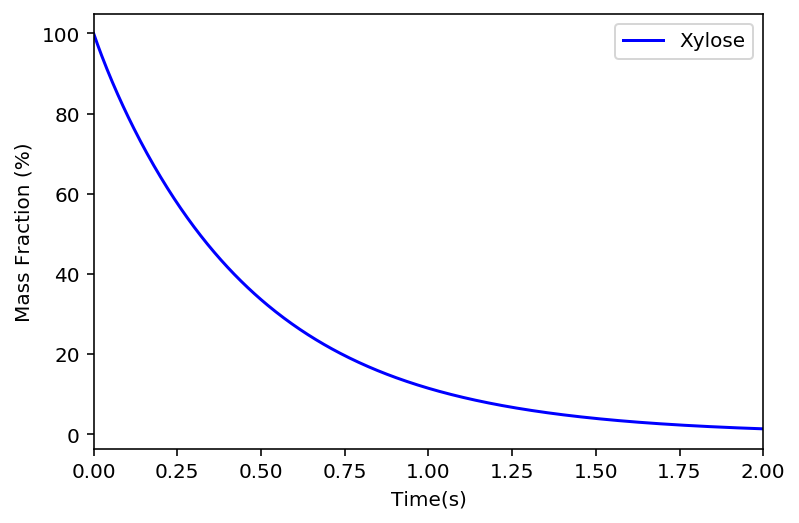

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(mod, mole_frac[:,speciesindices['O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O']] * 100, color="b" , label = 'Xylose')
# plt.plot(mod, mole_frac[:,speciesindices['O=O']] * 100, color="r" , label = 'O2')
# plt.plot(mod, mole_frac[:,speciesindices['O']] *100, color="g" , label = 'O2')

#plt.ylim(0,100)
plt.xlim(0,2)
plt.legend()
# plt.xlabel('Time(s)')

plt.xlabel('Time(s)')
plt.ylabel('Mass Fraction (%)')
#plt.yscale('log')

## Sensitivity Analysis

- Sensitivity analysis is the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be divided and allocated to different sources of uncertainty in its inputs. 
- Uncertainty Analysis characterizes the uncertainty in model prediction, without identifying which assump- tions are primarily responsible.
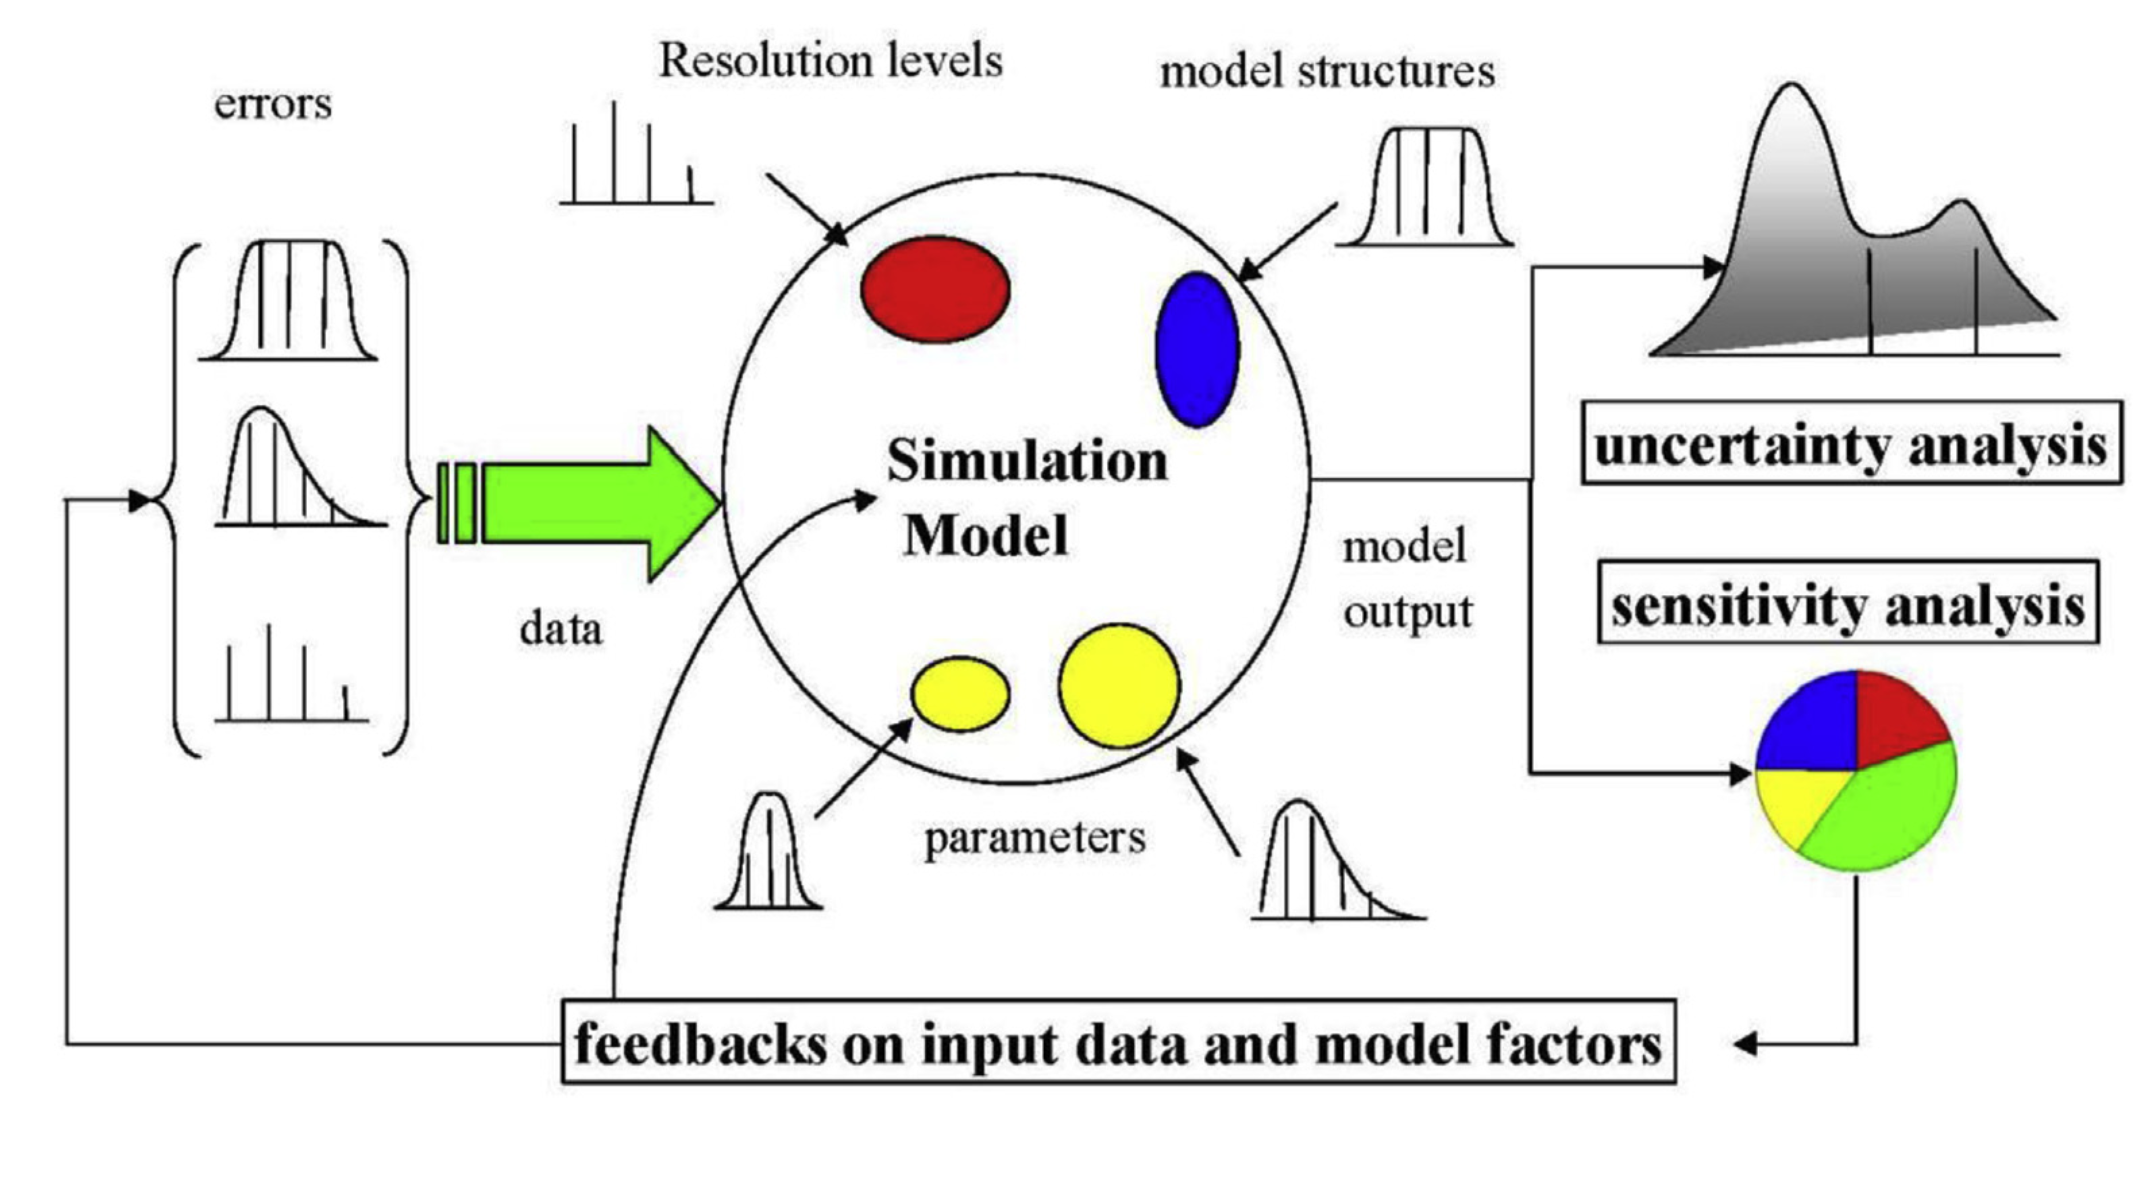

- CVODE has another version CVODES, which can do SA, but is not available through python
- Here, we used SALib to perform SA
- The Saltelli sampler generates N*(2D+2) samples, where in is the number of samples, and D the number of model inputs. The keyword argument **calc_second_order=False** will exclude second-order indices, resulting in a smaller sample matrix with 𝑁 * (𝐷 + 2) rows instead.

In [ ]:
#generate parameters for SA

setpath = '/Users/chowdhury/Documents/kmpy_results/SA_data/'
def gen_params(sample_number, input_file_name, output_file_name):
    
    cwd = os.getcwd()
    input_file = setpath + input_file_name
    print(input_file)
    output_file = setpath + output_file_name
    os.system('python -m SALib.sample.saltelli -n {} -p {} -o {}'.format(sample_number, input_file, output_file))

In [ ]:
gen_params(20,'params.txt','param_set.txt')

In [ ]:
len(forward_rate_constants)

In [ ]:
import io
cwd = os.getcwd()
setpath = '/Users/chowdhury/Documents/kmpy_results/SA_data_parallel/'
file_path_read = setpath + 'param_set.txt'
file_path_write = setpath +'model_solutions.txt'
file_input = setpath + 'params.txt'


In [ ]:

# read_file = open(file_path_read, "r")

# try:
#     os.remove(file_path_write)
# except:
#     pass
# #write_file = open(file_path_write, "a")

# i =1
# for aline in read_file:
    
#     kf_random = np.zeros((len(forward_rate_constants)), dtype = float)
#     values = list(map(float, aline.split()))
#     kf_random[:] = np.array(values[:len(forward_rate_constants)])
#     Temp = 773
#     kf_actual = np.array(build_kmatrix_forward(file_rateconstantlist, Temp))
#     kf_purturbed = np.array([actual * 10**(random) for actual, random in zip(kf_actual, kf_random)])
#     free_energy_dict = build_free_energy_dict(file_free_energy, Temp)
#     kr_purturbed = build_kmatrix_reverse(reac_prod_list, free_energy_dict, kf_purturbed, Temp )
#     mod, sim = stiff_ode_solver(unique_species, dydt_list, y0,
#                                 kf_purturbed, kr_purturbed)
    
#     text_trap = io.StringIO()
#     sys.stdout = text_trap
    
#     sys.stdout = sys.__stdout__ 
# #    write_file.write(str(mod))
#     with open(file_path_write, 'a') as f:
#         for item in sim[-1]:
#             f.write("%s\t" % item)
#         f.write('\n')
    
#     i = i+1
#     print(i)
#print(str(sim[-1,:]))

In [ ]:
def analyze_sensitivity(params_file, Y, column, delimiter, order, name,
                        parallel=False, processors=4):
    """
    Perform the sensitivity analysis after you have run your model
    with all the parameters from gen_params().  This is done from
    the command line because it is faster and gives the option to
    specify the column of the results file to analyze.  Parallel
    processing is possible.  Results are saved to a file using the
    name parameter.
    Parameters
    ----------
    problem    : str
                 the path to the saparams* file that contains
                 the problem definition.
    Y          : str
                 the path to the results file.  Results should
                 be in a file without a header.  Each line of the file must
                 contain results that correspond to the same line of the
                 param_sets generated in gen_params().
    column     : int
                 integer specifying the column number of the results to
                 analyze (zero indexed).
    delimiter  : str
                 string specifying the column delimiter used in the results.
    order      : int
                 the maximum order of sensitivity indices [1 or 2].
    name       : str
                 the name of the output measure to use when saving
                 the sensitivity analysis results to a file.
    parallel   : bool, optional
                 boolean indicating whether to use parallel processing.
    processors : int, optional
                 if parallel is True, this is an integer specifying the number
                 of processors to use.
    Returns
    --------
    None
    """
    out_file = setpath + 'analysis_{}.txt' .format(name)
    print(out_file)
    print(processors)
    if parallel:      
        os.system('python -m SALib.analyze.sobol -p {} -Y {} -c {} --delimiter {} '
             '--max-order {} --parallel --processors {} > {}'
             .format(params_file, Y, column, delimiter, order, processors, out_file))
    else:
        os.system('python -m SALib.analyze.sobol -p {} -Y {} -c {} '
             '--delimiter {} --maxorder {} > {}'
             .format(params_file, Y, column, delimiter, order, out_file))

In [ ]:
analyze_sensitivity(file_input, file_path_write, speciesindices['O=CCO'], "\'\t'", 2,'glycoaldehyde', parallel=True)

In [ ]:
analyze_sensitivity(file_input, file_path_write, speciesindices['O=Cc1ccco1'], "\'\t'", 2,'furfural', parallel=True)

## Need to create a parallel solver!!!

In [ ]:
setpath = '/Users/chowdhury/Documents/kmpy_results/SA_data/'
file_path_read = setpath + 'param_set.txt'
file_path_write = setpath +'model_solutions.txt'
file_input = setpath + 'params.txt'

In [ ]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

results = []
read_file = open(file_path_read, "r")

try:
    os.remove(file_path_write)
except:
    pass

# Step 1: define the function to evaluate
def func_solv(i, data, forward_rate, file_rateconstant, file_energy, complete_list, free_energy, uniquespecies, species_indices, dydtlist):
    
    

    kf_random = np.zeros((len(forward_rate)), dtype = float)
    values = list(map(float, data.split()))
    kf_random[:] = np.array(values[:len(forward_rate)])
    Temp = values[-1]
    kf_actual = np.array(build_kmatrix_forward(file_rateconstant, Temp))
    kf_purturbed = np.array([actual * 10**(random) for actual, random in zip(kf_actual, kf_random)])
    free_energy_dict = build_free_energy_dict(file_energy, Temp)
    kr = build_kmatrix_reverse(complete_list, free_energy, kf_purturbed, Temp )
    mod, sim = run_example(uniquespecies, species_indices, dydtlist, with_plots=False)
    print(i)
    text_trap = io.StringIO()
    sys.stdout = text_trap

    sys.stdout = sys.__stdout__ 

    return (i, sim[-1])

# Step 2: Define callback function to collect the output in `results`
def collect_result(result):
    global results
    results.append(result)
    

# Step 3: Use loop to parallelize
for i, data in enumerate(read_file):
    pool.apply_async(func_solv, args=(i, data, forward_rate_constants, file_rateconstantlist, file_free_energy, reac_prod_list, free_energy_dict, unique_species, speciesindices, dydt_list), callback=collect_result)

# Step 4: Close Pool and let all the processes complete
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.


# Step 5: Sort results [OPTIONAL]
results.sort(key=lambda x: x[0])
results_final = [r for i, r in results]


#    write_file.write(str(mod))
#         with open(file_path_write, 'a') as f:
#             for item in sim[-1]:
#                 f.write("%s\t" % item)
#             f.write('\n')

#         i = i+1
#         print(i)
    #print(str(sim[-1,:]))

In [ ]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

results = []


def func_solv_new(data, forward_rate, file_rateconstant, file_energy,
                  complete_list, uniquespecies, initial_y, dydtlist):

    kf_random = np.zeros((len(forward_rate)), dtype=float)
    values = list(map(float, data.split()))
    kf_random[:] = np.array(values[:len(forward_rate)])
    temp = values[-1] + 273
    kf_actual = np.array(build_kmatrix_forward(file_rateconstant, temp))
    kf_purturbed = np.array([actual * 10 ** rand for actual, rand in zip(kf_actual, kf_random)])
    free_energy_dict = build_free_energy_dict(file_energy, temp)
    kr_purturbed = build_kmatrix_reverse(complete_list, free_energy_dict, kf_purturbed, temp)
    mod, sim = stiff_ode_solver(uniquespecies, dydtlist, initial_y,
                                kf_purturbed, kr_purturbed) 

    return sim[-1]

def serial(readfile, forward_rate, file_rateconstant, file_energy, complete_list, free_energy, uniquespecies, species_indices, dydtlist):
    read_file = open(file_path_read, "r")
    return [func_solv_new(data, forward_rate, file_rateconstant, file_energy, complete_list, free_energy, uniquespecies, species_indices, dydtlist) for data in read_file]

def multiprocess(processes, file_read, forward_rate, file_rateconstant,
                 file_energy, complete_list,
                 uniquespecies, species_indices, dydtlist):

    read_file = open(file_read, "r")
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(func_solv_new, args=(
               data, forward_rate, file_rateconstant, file_energy, complete_list,
               uniquespecies, species_indices,
               dydtlist)) for data in read_file]
    results = [p.get() for p in results]
    results.sort(key=lambda x: x[0])  # to sort the results by input window width
    return results

In [ ]:
# import timeit


# benchmarks = []

# benchmarks.append(timeit.Timer('serial(file_path_read, forward_rate_constants, file_rateconstantlist, file_free_energy, reac_prod_list, free_energy_dict, unique_species, speciesindices, dydt_list)',
#             'from __main__ import serial, file_path_read, forward_rate_constants, file_rateconstantlist, file_free_energy, reac_prod_list, free_energy_dict, unique_species, speciesindices, dydt_list').timeit(number=1))

# benchmarks.append(timeit.Timer('multiprocess(2, file_path_read, forward_rate_constants, file_rateconstantlist, file_free_energy, reac_prod_list, free_energy_dict, unique_species, speciesindices, dydt_list)',
#             'from __main__ import multiprocess, file_path_read, forward_rate_constants, file_rateconstantlist, file_free_energy, reac_prod_list, free_energy_dict, unique_species, speciesindices, dydt_list').timeit(number=1))

# benchmarks.append(timeit.Timer('multiprocess(3, file_path_read, forward_rate_constants, file_rateconstantlist, file_free_energy, reac_prod_list, free_energy_dict, unique_species, speciesindices, dydt_list)',
#             'from __main__ import multiprocess, file_path_read, forward_rate_constants, file_rateconstantlist, file_free_energy, reac_prod_list, free_energy_dict, unique_species, speciesindices, dydt_list').timeit(number=1))

# benchmarks.append(timeit.Timer('multiprocess(4, file_path_read, forward_rate_constants, file_rateconstantlist, file_free_energy, reac_prod_list, free_energy_dict, unique_species, speciesindices, dydt_list)',
#             'from __main__ import multiprocess, file_path_read, forward_rate_constants, file_rateconstantlist, file_free_energy, reac_prod_list, free_energy_dict, unique_species, speciesindices, dydt_list').timeit(number=1))

#benchmarks.append(timeit.Timer('multiprocess(6, x_2Dgauss, point_x, widths)',
#            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

In [ ]:
result = multiprocess(4, file_path_read, forward_rate_constants, file_free_energy, reac_prod_list, unique_species, y0, dydt_list)



In [ ]:
result

try:
    os.remove(file_path_write)
except:
    pass


dataframe = pd.DataFrame.from_records(result)
dataframe.head()
dataframe.to_csv(file_path_write, sep = '\t', header = None, index = None)

In [ ]:
import platform
sys.stdout = io.StringIO()
sys.stdout = sys.__stdout__

def print_sysinfo():

    print('\nPython version  :', platform.python_version())
    print('compiler        :', platform.python_compiler())

    print('\nsystem     :', platform.system())
    print('release    :', platform.release())
    print('machine    :', platform.machine())
    print('processor  :', platform.processor())
    print('CPU count  :', mp.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')
    
def plot_results():
    bar_labels = ['serial', '2', '3', '4']

    fig = plt.figure(figsize=(10,8))

    # plot bars
    y_pos = np.arange(len(benchmarks))
    plt.yticks(y_pos, bar_labels, fontsize=16)
    bars = plt.barh(y_pos, benchmarks,
             align='center', alpha=0.4, color='g')

    # annotation and labels

    for ba,be in zip(bars, benchmarks):
        print('{}'.format(ba.get_width() + 2))
        plt.text(ba.get_width() + 2, ba.get_y() + ba.get_height()/2,
                '{0:.2%}'.format(benchmarks[0]/be),
                ha='center', va='bottom', fontsize=12)

    plt.xlabel('time in seconds', fontsize=14)
    plt.ylabel('number of processes', fontsize=14)
    t = plt.title('Serial vs. Multiprocessing', fontsize=18)
    plt.ylim([-1,len(benchmarks)+0.5])
    plt.xlim([0,max(benchmarks)*1.1])
    plt.vlines(benchmarks[0], -1, len(benchmarks)+0.5, linestyles='dashed')
    plt.grid()

    plt.show()

In [ ]:

plot_results()
print_sysinfo()


In [ ]:
values = pd.read_csv('/Users/chowdhury/Documents/kmpy_results/SA_data/model_solutions.txt', sep = '\t', header = None).values

In [ ]:
len(values[1,:])

In [ ]:
wt_xylose = Descriptors.MolWt(Chem.MolFromSmiles('O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'))
x = values[:,speciesindices['O=Cc1ccco1']]* 100 * Descriptors.MolWt(Chem.MolFromSmiles('O=Cc1ccco1')) / wt_xylose
y = values[:,speciesindices['O=CCO']]* 100 * Descriptors.MolWt(Chem.MolFromSmiles('O=CCO')) / wt_xylose

# x = values[:,speciesindices['O=Cc1ccco1']]
# y = values[:,speciesindices['O=CCO']]
plt.scatter(x, y)
plt.show()

In [ ]:
print(max(values[:,speciesindices['O=CCO']]))